In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from os import sys
import copy
from pyDOE import lhs
from Sequence_Sampling import Sequence_Sampling

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
NVIDIA GeForce GTX 1650 Ti


In [5]:
dtype=torch.float

def dfx(x,f):
    gopts = torch.ones(x.shape, dtype=dtype, device = torch.device('cuda:0'))
    return torch.autograd.grad([f], [x], grad_outputs=gopts, create_graph=True)[0]

def d2fx(x,f):
    gopts = torch.ones(x.shape, dtype=dtype, device = torch.device('cuda:0'))
    return torch.autograd.grad(dfx(x,f), [x], grad_outputs=gopts, create_graph=True)[0]

In [6]:
class mySin(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input).cuda()

In [7]:
class NNs(nn.Module):
    def __init__(self):
        super(NNs,self).__init__()
        
        self.activation = mySin()
        # self.activation = torch.nn.Tanh()
        self.input_En = nn.Linear(1,1).cuda()
        
        self.hl1 = nn.Linear(2, 64).cuda()
        
        self.hl2 = nn.Linear(64, 64).cuda()
        
        self.output_layer = nn.Linear(64, 1).cuda()
        
    def forward(self, X):

        En_out = self.input_En(torch.ones_like(X))


        hl1 = self.activation(self.hl1(torch.cat((X.cuda(),En_out),1)))
        
        # print(hl1.shape)
        # sys.exit()
        hl2 = self.activation(self.hl2(hl1)).cuda()

        output = self.output_layer(hl2).cuda()
        return output.cuda(),En_out.cuda()
    def psi(self,x):
        x = torch.tensor(x, requires_grad=True).float().view(-1,1).cuda()
        y,En=self.forward(x)
        psi = (
            (1 - torch.exp(-1.0 * (x - 0))) *
            (1 - torch.exp(-1.0 * (1 - x))) *
            y[:, 0:1]
        )
        return psi
    def visualize_psi(self,x):
        psi=self.psi(x)
        plt.plot(x, psi.cpu().detach().numpy(), label='Predictions')
        plt.xlabel('Input')
        plt.ylabel('Output')
        plt.title('Predicted Output')
        plt.legend()
        plt.show()

In [8]:
class PINNs():
    def __init__(self,X):
        self.x = torch.tensor(X, requires_grad=True).float().cuda()
        
        self.nn = NNs()
        self.walle=-4
        
        self.error_hist=[]
        self.x_test = np.linspace(0, 1, 100)
        betas = [0.999, 0.9999]
        self.optimizer = torch.optim.Adam(self.nn.parameters(), lr=0.008, betas=betas) 
    def output_transform(self,x, y):
        y_out = (
            (1 - torch.exp(-1.0 * (x - 0))) *
            (1 - torch.exp(-1.0 * (1 - x))) *
            y[:, 0:1]
        )
        return y_out
    
    def net_u_En(self, x):
        u,En = self.nn.forward(x)
        u = self.output_transform(x,u)
        return u,En
    
    
    def pde_loss(self, x, psi,E):
        dpsi_dx2=d2fx(x, psi).cuda()
      
        pde_residual = dpsi_dx2/2 + E.cuda()*psi.cuda()
        
        pde_loss= (pde_residual.pow(2)).mean()
        
        return pde_loss
    
    def nontriv_loss(self, x, psi,E):
        
        nontriv_loss= 1/(psi.pow(2).mean()+1e-06)
        
        return nontriv_loss
    
    def Enontriv_loss(self, x, psi,E):
        
        Enontriv_loss= 1/(E.pow(2).mean()+1e-06)
        
        return Enontriv_loss
    
    def eigen_loss(self,x,psi,E):
        eigen_loss=torch.exp(-1*E+self.walle).mean()
        
        return eigen_loss

    def loss(self):
        psi,En = self.net_u_En(self.x)
        
        pde_loss=self.pde_loss(self.x, psi, En).cuda()
        nontriv_loss=self.nontriv_loss(self.x, psi, En).cuda()
        Enontriv_loss=self.Enontriv_loss(self.x, psi, En).cuda()
        eigen_loss=self.eigen_loss(self.x,psi,En)
        
        Ltot= pde_loss+ nontriv_loss+Enontriv_loss+eigen_loss
        
        return Ltot
    
    def train(self, num_iterations):
        Loss_history = []
        En_history = []
        di = (None, 1e+20)
        dic = {0:di, 1:di, 2:di, 3:di, 4:di, 5:di, 6:di, 7:di, 8:di, 9:di, 10:di,11:di,12:di,13:di,14:di,15:di}
        last_psi_L = 0
        Llim =  1e+20
        
        pde_loss_history = []
        
        nontriv_loss_history = []
        
        Ennontriv_loss_history = []
        criteria_loss_history = []
        
        eigen_loss_history = []
        EWall_history = []
        
        for i in range(num_iterations):
            
            psi,En=self.net_u_En(self.x)
            
            ### Loss Log
            loss=self.loss().cuda()
            
            Loss_history.append(loss.item())
            En_history.append(En[0].item())
            
            pde_loss_history.append(self.pde_loss(self.x, psi, En).item())
            eigen_loss_history.append(self.eigen_loss(self.x, psi, En).item())
            nontriv_loss_history.append(self.nontriv_loss(self.x, psi, En).item())
            Ennontriv_loss_history.append(self.Enontriv_loss(self.x, psi, En).item())
            EWall_history.append(self.walle)
            ###
            
            
            ### Optimization
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            ###
            
            criteria_loss=loss
            if  criteria_loss < Llim:
                fc1 =  copy.deepcopy(self.nn)
                Llim=criteria_loss
    
            E_bin = abs(En[0].data.tolist()[0]//10) 
            if criteria_loss < dic[E_bin][1]:
              dic[E_bin] = (copy.deepcopy(self.nn.cuda()), criteria_loss)
            
            if i % 10000== 0:
                
                print("Iteration:", i, "Loss:", loss.item())
                print("Energy:",En[0][0].item())
     
            # error=np.abs((self.analytical**2)-self.predict(self.x_test)**2).mean()
            # self.error_hist.append(error)
            
            if i%2500 == 0:
              self.walle += 1
              # X=lhs(num_dimensions, samples=num_samples, criterion='maximin')
              # self.x = torch.tensor(X, requires_grad=True).float()
            
            if i % 50000 == 0:
                # print(self.predict(self.x_test)[0])
                # sys.exit()
                # print("Iteration:", i, "Error:", error)
                print("Iteration:", i, "Loss:", loss.item())
                print("Iteration:", i, "En:", En[0])
                plt.plot(self.x_test, -self.predict(self.x_test)[0], label='Predictions')
                plt.xlabel('Input')
                plt.ylabel('Output')
                plt.title('Predicted Output')
                
                # plt.plot(self.x_test, self.analytical**2, label='True',color='maroon')
                plt.legend()
                plt.show()
               

        loss_histories = (Loss_history,En_history,pde_loss_history,eigen_loss_history,nontriv_loss_history,Ennontriv_loss_history,EWall_history,dic)
        return fc1,loss_histories
     
    def predict(self, x_test):
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1).cuda()

        with torch.no_grad():
            psi,En = self.net_u_En(x_test_tensor)

        return psi.cpu().numpy(),En.cpu().numpy()

In [9]:
num_samples = 100
num_dimensions = 1 # Number of dimensions in your input space

X_latinhypercube = lhs(num_dimensions, samples=num_samples, criterion='maximin')

generator=Sequence_Sampling(100,1)  
X_vandercorput=generator.halton()

Iteration: 0 Loss: 3327.551513671875
Energy: 0.40688133239746094
Iteration: 0 Loss: 3327.551513671875
Iteration: 0 En: tensor([0.4069], device='cuda:0', grad_fn=<SelectBackward0>)


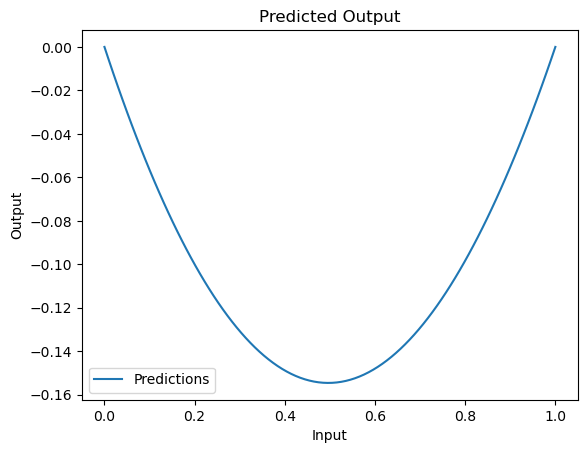

Iteration: 10000 Loss: 0.18163518607616425
Energy: 4.880428314208984
Iteration: 20000 Loss: 0.4998169243335724
Energy: 4.94957971572876
Iteration: 30000 Loss: 6.8653693199157715
Energy: 7.005412578582764
Iteration: 40000 Loss: 15.06297492980957
Energy: 10.798336029052734
Iteration: 50000 Loss: 0.15877190232276917
Energy: 19.73672103881836
Iteration: 50000 Loss: 0.15877190232276917
Iteration: 50000 En: tensor([19.7367], device='cuda:0', grad_fn=<SelectBackward0>)


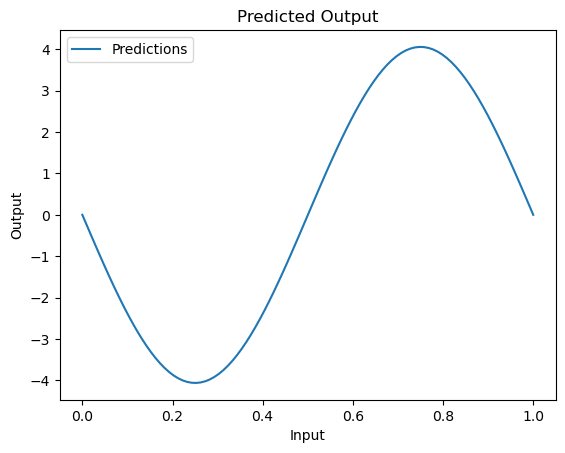

Iteration: 60000 Loss: 1.3565760850906372
Energy: 19.788232803344727
Iteration: 70000 Loss: 9.184954643249512
Energy: 23.533742904663086
Iteration: 80000 Loss: 17.179914474487305
Energy: 27.51820182800293
Iteration: 90000 Loss: 25.14095687866211
Energy: 31.333890914916992
Iteration: 100000 Loss: 0.17511744797229767
Energy: 44.41095733642578
Iteration: 100000 Loss: 0.17511744797229767
Iteration: 100000 En: tensor([44.4110], device='cuda:0', grad_fn=<SelectBackward0>)


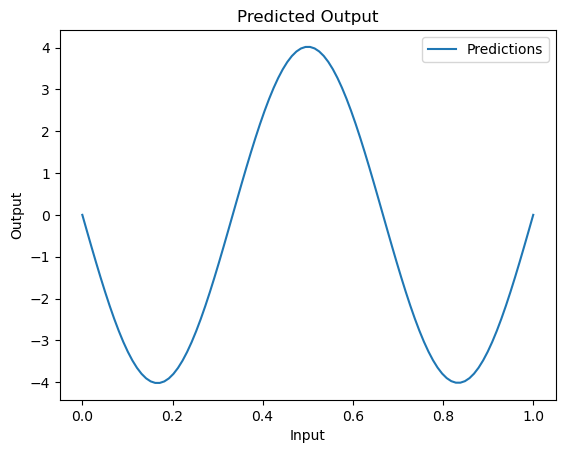

Iteration: 110000 Loss: 0.10195809602737427
Energy: 44.41362762451172
Iteration: 120000 Loss: 0.7681431174278259
Energy: 44.428741455078125
Iteration: 130000 Loss: 7.788963317871094
Energy: 47.33649444580078
Iteration: 140000 Loss: 15.823983192443848
Energy: 51.498390197753906
Iteration: 150000 Loss: 23.790306091308594
Energy: 55.24406433105469
Iteration: 150000 Loss: 23.790306091308594
Iteration: 150000 En: tensor([55.2441], device='cuda:0', grad_fn=<SelectBackward0>)


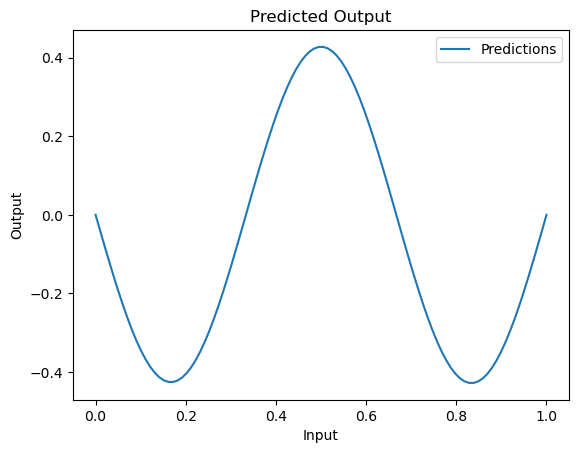

Iteration: 160000 Loss: 31.785297393798828
Energy: 59.30333709716797
Iteration: 170000 Loss: 6.075584411621094
Energy: 75.93546295166016
Iteration: 180000 Loss: 0.29506435990333557
Energy: 78.95960998535156
Iteration: 190000 Loss: 0.18582400679588318
Energy: 78.956787109375
Iteration: 200000 Loss: 0.30351728200912476
Energy: 78.96014404296875
Iteration: 200000 Loss: 0.30351728200912476
Iteration: 200000 En: tensor([78.9601], device='cuda:0', grad_fn=<SelectBackward0>)


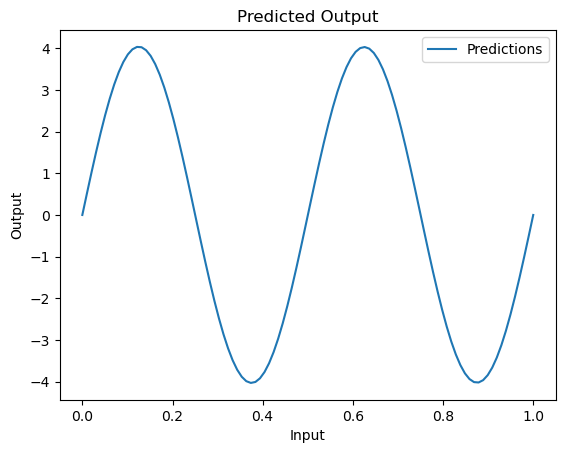

Iteration: 210000 Loss: 2.7442286014556885
Energy: 79.14056396484375
Iteration: 220000 Loss: 10.76390552520752
Energy: 83.57122802734375
Iteration: 230000 Loss: 18.749637603759766
Energy: 87.54086303710938
Iteration: 240000 Loss: 26.696826934814453
Energy: 91.26895141601562
Iteration: 250000 Loss: 34.94346618652344
Energy: 94.84562683105469
Iteration: 250000 Loss: 34.94346618652344
Iteration: 250000 En: tensor([94.8456], device='cuda:0', grad_fn=<SelectBackward0>)


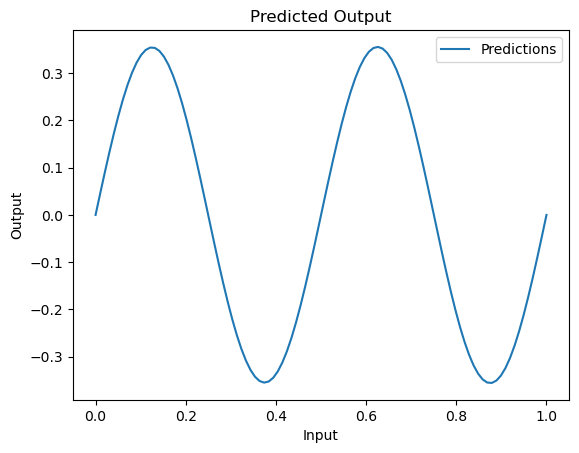

Iteration: 260000 Loss: 47.66661071777344
Energy: 97.68486785888672
Iteration: 270000 Loss: 47.98868179321289
Energy: 102.26331329345703
Iteration: 280000 Loss: 34.22744369506836
Energy: 107.27998352050781
Iteration: 290000 Loss: 23.403154373168945
Energy: 112.11343383789062


In [10]:
iterations=300000

pinns = PINNs(X_latinhypercube)
model1,hist=pinns.train(iterations)


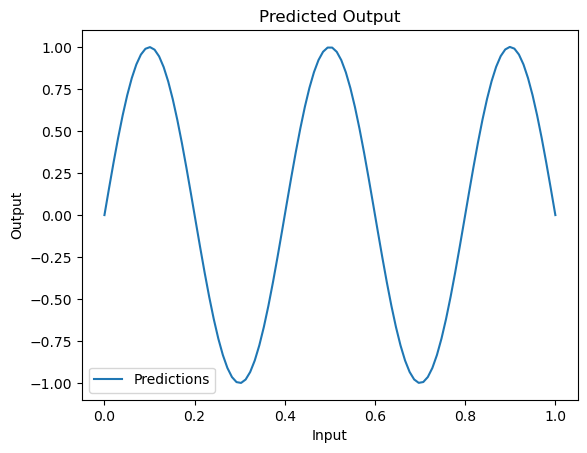

In [32]:
x_test = np.linspace(0, 1, 100)
predictions,En = pinns.predict(x_test)


plt.plot(x_test, predictions/np.max(predictions), label='Predictions')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Predicted Output')
plt.legend()
plt.show()


<div style="font-family: 'Latin Modern Roman', serif; font-size: 18px; margin-bottom: 30px;">
Time independent Schrödinger equation of infinite square well is:
</div>

<div style="font-family: 'Latin Modern Roman', serif; font-size: 18px; margin-bottom: 30px;">
\begin{equation*}
\left[ \frac{-\hbar^2}{2m} \frac{\mathrm{d}^2 }{\mathrm{d}x^2} + V(x) \right] \psi = E\psi
\end{equation*}
</div>


<div style="font-family: 'Latin Modern Roman', serif; font-size: 18px; margin-bottom: 30px;">
Where:
</div>

<div style="font-family: 'Latin Modern Roman', serif; font-size: 18px; margin-bottom: 30px;">
\begin{equation*}
V(x) = \begin{cases} 
0 & \text{if } 0 \leq x \leq 1 \\
\infty & \text{otherwise}
\end{cases}
\end{equation*}
</div>

<div style="font-family: 'Latin Modern Roman', serif; font-size: 18px; margin-bottom: 30px;">
$\hbar$ and $m$ can be set to 1 without losing any generality
</div>

<div style="font-family: 'Latin Modern Roman', serif; font-size: 18px; margin-bottom: 30px;">
Solution of this eigenvalue problem:
</div>

<div style="font-family: 'Latin Modern Roman', serif; font-size: 18px; margin-bottom: 30px;">
\begin{equation*}    
\psi_n(x) = \begin{cases} 
\sqrt{2} \sin(n\pi x) & \text{if } 0 \leq x \leq 1 \\
0 & \text{otherwise}
\end{cases}
\end{equation*}

\begin{equation*} 
    E_{n} = \frac{n^2 \pi^2}{2} 
\end{equation*}
    
Where $n$ represents the energy states.

Therefore, we expect to obtain minimum loss at these energy levels, and associiated wavefunction
</div>

<div style="font-family: 'Latin Modern Roman', serif; font-size: 18px; margin-bottom: 30px;">
\begin{equation*}
\psi_{1}=\sqrt{2} \sin(\pi x)  \quad \text{ and } \quad E_{1}= \frac{\pi^2}{2}=4.934
\end{equation*}
\begin{equation*}
\psi_{2}=\sqrt{2} \sin(2\pi x)  \quad \text{ and } \quad E_{2}= \frac{4\pi^2}{2}=19.739
\end{equation*}
\begin{equation*}
\psi_{3}=\sqrt{2} \sin(3\pi x)  \quad \text{ and } \quad E_{3}= \frac{9\pi^2}{2}=44.413
\end{equation*}
\begin{equation*}
\psi_{4}=\sqrt{2} \sin(4\pi x)  \quad \text{ and } \quad E_{4}= \frac{16\pi^2}{2}=78.956
\end{equation*}
\begin{equation*}
\psi_{5}=\sqrt{2} \sin(5\pi x)  \quad \text{ and } \quad E_{5}= \frac{25\pi^2}{2}=123.37
\end{equation*}
</div>

<div style="font-family: 'Latin Modern Roman', serif; font-size: 28px; margin-bottom: 30px;">
\begin{equation*}
\mathcal{L}_{Schrodinger}=\frac{1}{2} \frac{\mathrm{d}^2 }{\mathrm{d}x^2}\psi + E\psi
\end{equation*}
</div>

<div style="font-family: 'Latin Modern Roman', serif; font-size: 28px; margin-bottom: 30px;">
\begin{equation*}
\mathcal{L}_{Eigen}= e^{-E+c}
\end{equation*}
</div>

<div style="font-family: 'Latin Modern Roman', serif; font-size: 28px; margin-bottom: 30px;">
\begin{equation*}
\mathcal{L}_{Psinontriv}=(\frac{1}{\psi(x,E)})^2
\end{equation*}
</div>

<div style="font-family: 'Latin Modern Roman', serif; font-size: 28px; margin-bottom: 30px;">
\begin{equation*}
\mathcal{L}_{Enontriv}=(\frac{1}{E})^2
\end{equation*}
</div>

In [11]:
vepoch=np.arange(iterations)

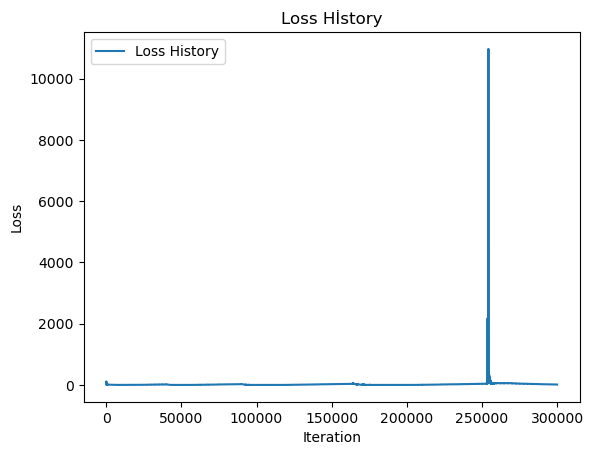

In [12]:
plt.plot(vepoch[1:], hist[0][1:], label='Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Hİstory')
plt.legend()
plt.show()

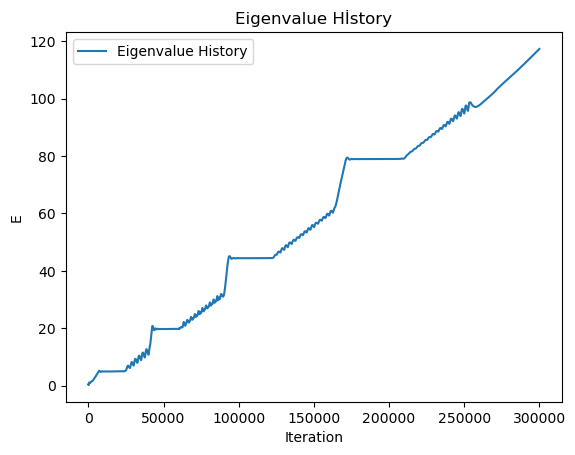

In [13]:
plt.plot(vepoch[1:], hist[1][1:], label='Eigenvalue History')
plt.xlabel('Iteration')
plt.ylabel('E')
plt.title('Eigenvalue Hİstory')
plt.legend()
plt.show()

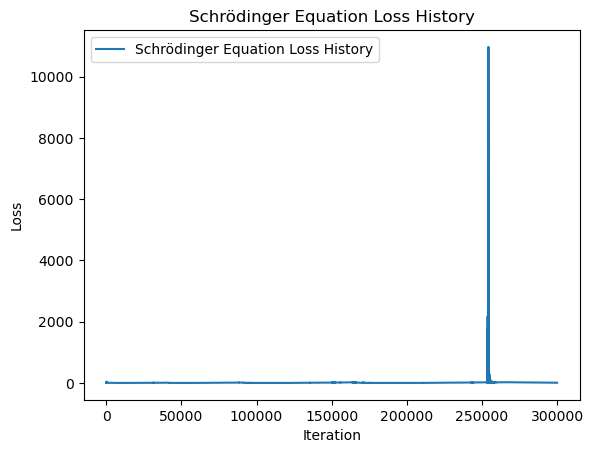

In [14]:
plt.plot(vepoch[1:], hist[2][1:], label='Schrödinger Equation Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Schrödinger Equation Loss History')
plt.legend()
plt.show()

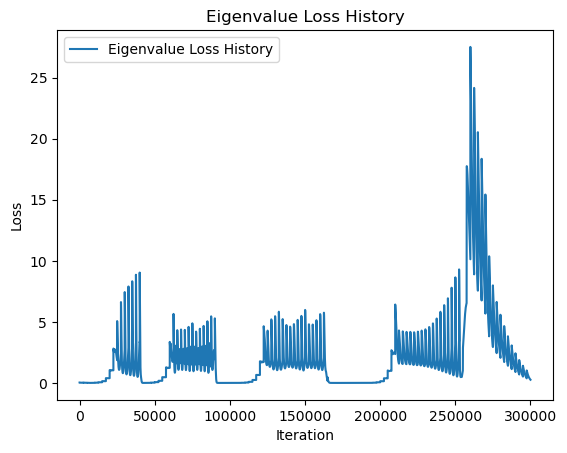

In [15]:
plt.plot(vepoch[1:], hist[3][1:], label='Eigenvalue Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Eigenvalue Loss History')
plt.legend()
plt.show()

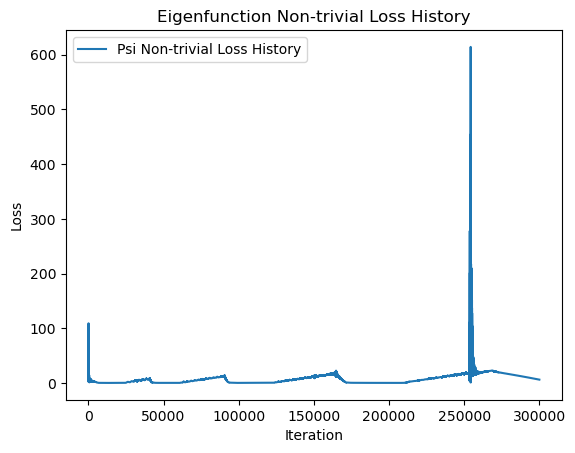

In [16]:
plt.plot(vepoch[1:], hist[4][1:], label='Psi Non-trivial Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Eigenfunction Non-trivial Loss History')
plt.legend()
plt.show()   

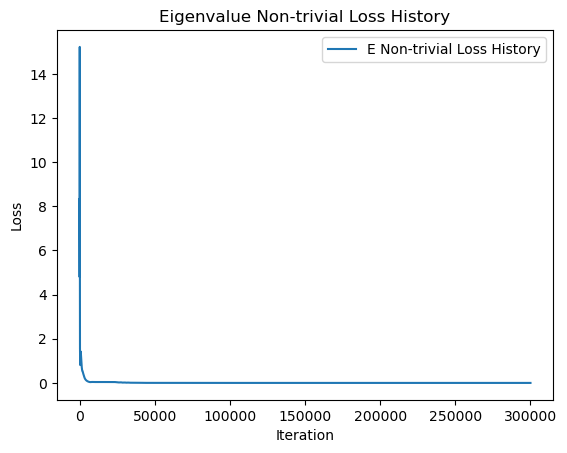

In [20]:
plt.plot(vepoch[1:], hist[5][1:], label='E Non-trivial Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Eigenvalue Non-trivial Loss History')
plt.legend()
plt.show()

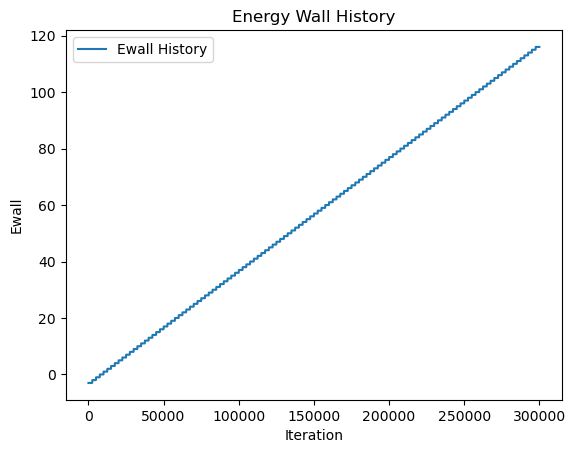

In [21]:
plt.plot(vepoch[1:], hist[6][1:], label='Ewall History')
plt.xlabel('Iteration')
plt.ylabel('Ewall')
plt.title('Energy Wall History')
plt.legend()
plt.show()  

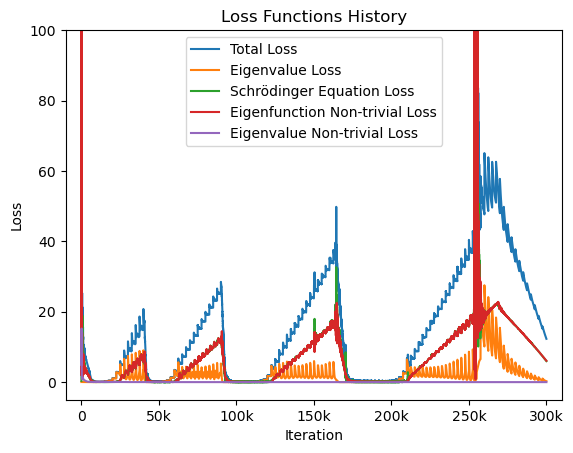

In [29]:
plt.plot(vepoch[1:], hist[0][1:], label='Total Loss')
plt.plot(vepoch[1:], hist[3][1:], label='Eigenvalue Loss')
plt.plot(vepoch[1:], hist[2][1:], label='Schrödinger Equation Loss')
plt.plot(vepoch[1:], hist[4][1:], label='Eigenfunction Non-trivial Loss')
plt.plot(vepoch[1:], hist[5][1:], label='Eigenvalue Non-trivial Loss')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Functions History')

# Rescale the x-axis
plt.xlim(-10000, 310000)
plt.xticks([0,50000, 100000,150000, 200000,250000, 300000], ['0','50k', '100k','150k', '200k','250k', '300k'])

# Rescale the y-axis
plt.ylim(-5, 100)

# Add legend
plt.legend()

# Show the plot
plt.show()

## Analytical Solutions

In [33]:
def fpsi(x,n):
    return np.sqrt(2)*np.sin(n*np.pi*x)
def En(n):
    return (np.pi**2*n**2)/2   

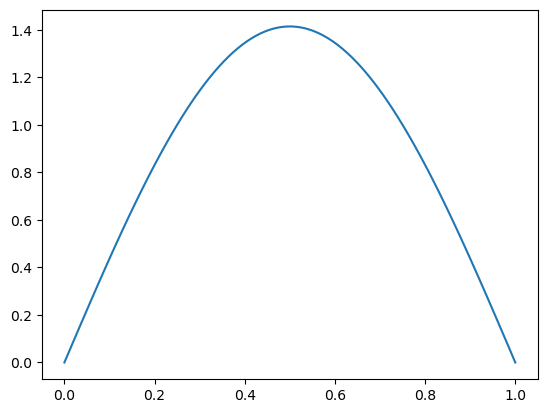

4.934802200544679


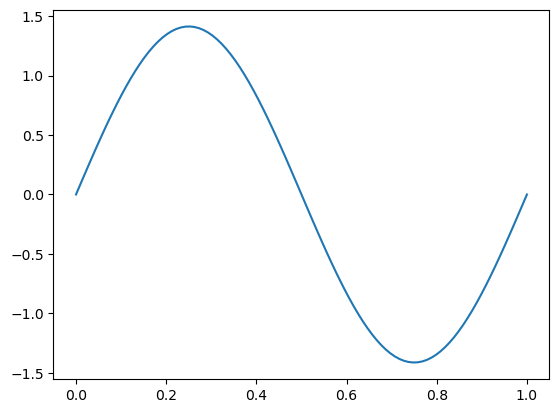

19.739208802178716


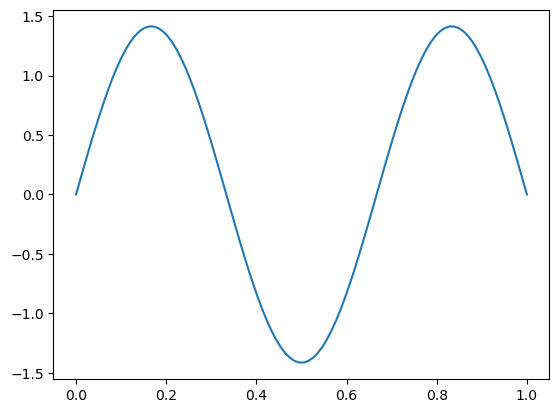

44.41321980490211


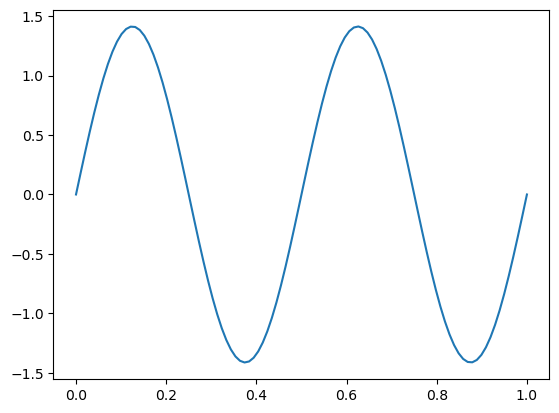

78.95683520871486


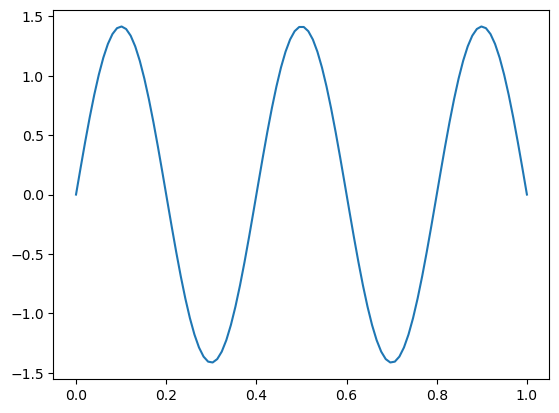

123.37005501361698


In [34]:
vpsi=[]
vEn=[]
for n in range(1,6):
    psi=fpsi(x_test,n)
    E=En(n)
    plt.plot(x_test,psi)
    plt.show()
    vpsi.append(psi)
    vEn.append(E)
    print(E)

In [36]:
psi_1=hist[-1][0][0].cuda()
psi_2=hist[-1][1][0].cuda()
psi_3=hist[-1][4][0].cuda()
psi_4=hist[-1][7][0].cuda()

In [48]:
psi1=psi_1.psi(x_test)
psi2=psi_2.psi(x_test)
psi3=psi_3.psi(x_test)
psi4=psi_4.psi(x_test)


def visualize_psi(x,psi,n):
 
    psi=psi.cpu().detach().numpy()
    plt.plot(x_test, (-psi)/np.max(np.abs(psi)), label='PINN',color='maroon')
    plt.plot(x_test,(vpsi)[n-1]/np.max(np.abs(vpsi[n-1])),label='Analytic',linestyle='dashed',color='green')
    plt.xlabel('x')
    plt.ylabel('Psi')
    plt.title('Analytic vs. PINN')
    plt.legend()
    plt.show()

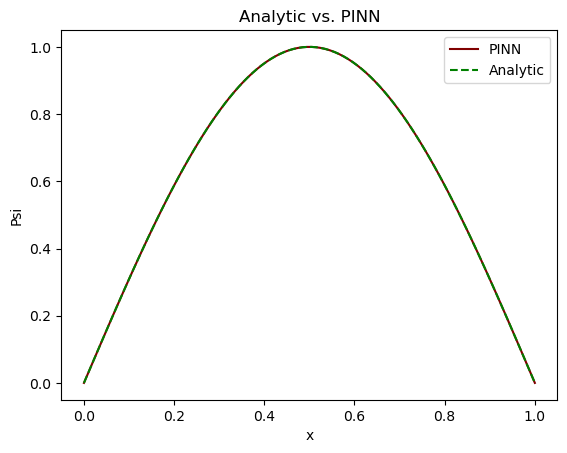

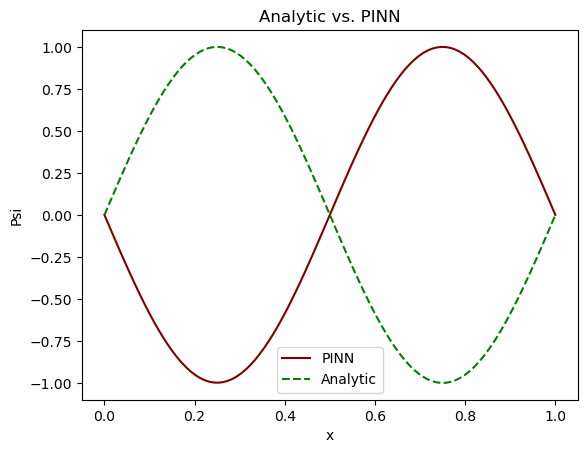

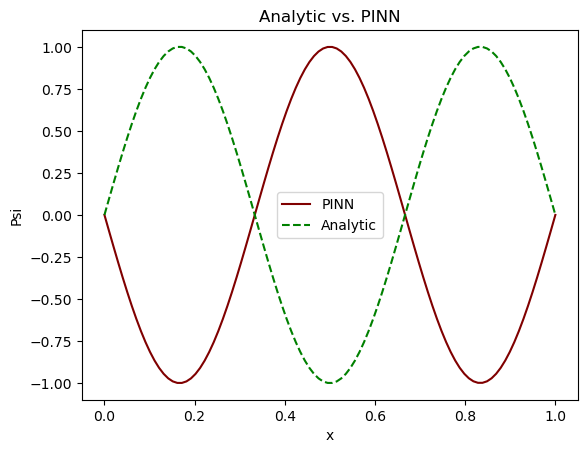

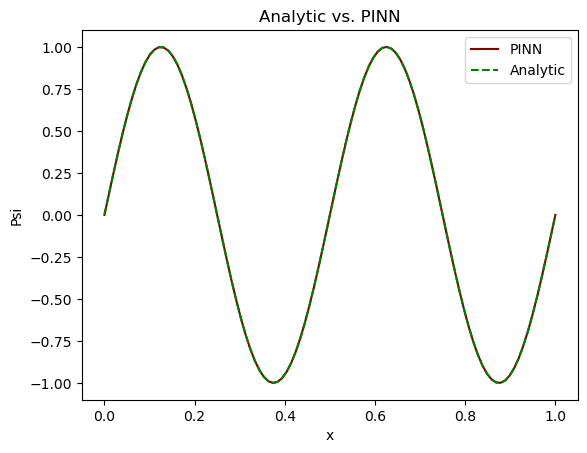

In [49]:
visualize_psi(x_test,psi1,n=1)
visualize_psi(x_test,psi2,n=2)
visualize_psi(x_test,psi3,n=3)
visualize_psi(x_test,psi4,n=4)